## Implementing our first neural network
One of the stepping stones to the introduction of neural networks is to implement a neural network that is able to classify digits. For this task, we will be using the famous MNIST dataset made available at http://yann.lecun.com/exdb/mnist/. 
### Preparing the data
First, we need to download the dataset with the download_data(...) function and preprocess it with the read_mnist(...) function. 

In [2]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# to down the data
import struct
import gzip
import os
from six.moves.urllib.request import urlretrieve

In [3]:
def download_data(url, filename, expected_bytes, force=False):
    """Download a file if not present and make sure its the right size"""
    if force or not os.path.exists(filename):
        print('Attempting to download: ', filename)
        filename, _ = urlretrieve(url + filename, filename)
        print('\nDownload complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get it using your browser?.'
        )
    return filename

# Download data if needed
url = 'http://yann.lecun.com/exdb/mnist/'
# training data
download_data(url,'train-images-idx3-ubyte.gz',9912422)
download_data(url,'train-labels-idx1-ubyte.gz',28881)
# testing data
download_data(url,'t10k-images-idx3-ubyte.gz',1648877)
download_data(url,'t10k-labels-idx1-ubyte.gz',4542)

Attempting to download:  train-images-idx3-ubyte.gz

Download complete!
Found and verified train-images-idx3-ubyte.gz
Attempting to download:  train-labels-idx1-ubyte.gz

Download complete!
Found and verified train-labels-idx1-ubyte.gz
Attempting to download:  t10k-images-idx3-ubyte.gz

Download complete!
Found and verified t10k-images-idx3-ubyte.gz
Attempting to download:  t10k-labels-idx1-ubyte.gz

Download complete!
Found and verified t10k-labels-idx1-ubyte.gz


't10k-labels-idx1-ubyte.gz'

## Read Data without Preprocessing 
Reading the byte stream of the dataset and forming it into a proper numpy.ndarray object

In [7]:
def read_mnist(fname_img, fname_lbl):
    print('\nReading files %s and %s' %(fname_img, fname_lbl))
    
    with gzip.open(fname_img) as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        print(num, rows, cols)
        img = (np.frombuffer(fimg.read(num*rows*cols), dtype=np.uint8).reshape(num, rows*cols)).astype(np.float32)
        print('(Images) REturned a tensor of shape ', img.shape)
        
        img = (img - np.mean(img)) /np.std(img)
    
    with gzip.open(fname_lbl) as flbl:
        #flbl.read(8) reads upto 8 bytes
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.frombuffer(flbl.read(num), dtype=np.int8)
        print('(Lables) Returned a tensro of shape: %s' %lbl.shape)
        print('Sample labels: ', lbl[:10])
   
    return img, lbl
        

In [8]:
# Read the training and testing data
train_inputs, train_labels = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_inputs, test_labels = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


Reading files train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz
60000 28 28
(Images) REturned a tensor of shape  (60000, 784)
(Lables) Returned a tensro of shape: 60000
Sample labels:  [5 0 4 1 9 2 1 3 1 4]

Reading files t10k-images-idx3-ubyte.gz and t10k-labels-idx1-ubyte.gz
10000 28 28
(Images) REturned a tensor of shape  (10000, 784)
(Lables) Returned a tensro of shape: 10000
Sample labels:  [7 2 1 0 4 1 4 9 5 9]


# defining Hyperparameters and some constants

In [51]:
WEIGHTS_STRING = 'weights'
BIAS_STRING = 'bias'

batch_size = 100

img_width, img_height = 28,28
input_size = img_height * img_width
num_labels = 10

# resets the default graph Otherwise raises an error about already initialized variables
tf.reset_default_graph() 

## Defining Input and Label Placeholders¶

In [52]:
tf_inputs = tf.placeholder(shape=[batch_size, input_size], dtype=tf.float32, name='inputs')
tf_labels = tf.placeholder(shape=[batch_size, num_labels], dtype=tf.float32, name='labels')

# Define the weights and biases Variables (with scoping)

In [53]:
# Defining the Tensorflow variables
def define_net_parameters():
    with tf.variable_scope('layer1'):
        tf.get_variable(WEIGHTS_STRING,shape=[input_size,500],
                            initializer=tf.random_normal_initializer(0,0.02))
        tf.get_variable(BIAS_STRING, shape=[500],
                           initializer=tf.random_uniform_initializer(0,0.01))
        
    with tf.variable_scope('layer2'):
        tf.get_variable(WEIGHTS_STRING,shape=[500,250],
                            initializer=tf.random_normal_initializer(0,0.02))
        tf.get_variable(BIAS_STRING, shape=[250],
                           initializer=tf.random_uniform_initializer(0,0.01))
    
    with tf.variable_scope('layer3'):
        tf.get_variable(WEIGHTS_STRING,shape=[250,125],
                            initializer=tf.random_normal_initializer(0,0.02))
        tf.get_variable(BIAS_STRING, shape=[125],
                           initializer=tf.random_uniform_initializer(0,0.01))
        
    with tf.variable_scope('output'):
        tf.get_variable(WEIGHTS_STRING,shape=[125,10],
                            initializer=tf.random_normal_initializer(0,0.02))
        tf.get_variable(BIAS_STRING, shape=[10],
                           initializer=tf.random_uniform_initializer(0,0.01))

## Defining the Inference Operation
Here we calculate the output logits (unnormalized scores) for a given input x

In [54]:
#define the logits 
def inference(x):
    # calculations for layer 1
    with tf.variable_scope('layer1',reuse=True):
        w,b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_h1 = tf.nn.relu(tf.matmul(x,w) + b, name = 'hidden1')

    # calculations for layer 2
    with tf.variable_scope('layer2',reuse=True):
        w,b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_h2 = tf.nn.relu(tf.matmul(tf_h1,w) + b, name = 'hidden1')
        
     # calculations for layer 3
    with tf.variable_scope('layer3',reuse=True):
        w,b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_h3 = tf.nn.relu(tf.matmul(tf_h2,w) + b, name = 'hidden1')

    # calculations for output layer
    with tf.variable_scope('output',reuse=True):
        w,b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_logits = tf.nn.bias_add(tf.matmul(tf_h3,w), b, name = 'logits')

    return tf_logits

## Defining Loss function and optimizer 
we use the cross entropy loss function and a momentum-based optimizer for learning

In [55]:
define_net_parameters()

# defining the loss
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=inference(tf_inputs), labels=tf_labels))

# defining the optimize function
tf_loss_minimize = tf.train.MomentumOptimizer(momentum=0.9,learning_rate=0.01).minimize(tf_loss)

## Defining Predictions

In [58]:
#defining predictions
tf_predictions = tf.nn.softmax(inference(tf_inputs))

## Executing the Graph to get the Classification Results

In [59]:
session = tf.InteractiveSession()

tf.global_variables_initializer().run()

NUM_EPOCHS = 50

def accuracy(predictions, labels):
    ''' Measure the classification accuracy of some predictions (softmax outputs) 
    and labels (integer class labels)'''
    return np.sum(np.argmax(predictions,axis=1).flatten()==labels.flatten())/batch_size

test_accuracy_over_time = []
train_loss_over_time = []
for epoch in range(NUM_EPOCHS):
    train_loss = []
    
    # Training Phase 
    for step in range(train_inputs.shape[0]//batch_size):
        # Creating one-hot encoded labels with labels
        # One-hot encoding dight 3 for 10-class MNIST data set will result in
        # [0,0,0,1,0,0,0,0,0,0]
        labels_one_hot = np.zeros((batch_size, num_labels),dtype=np.float32)
        labels_one_hot[np.arange(batch_size),train_labels[step*batch_size:(step+1)*batch_size]] = 1.0
        
        # Printing the one-hot labels
        if epoch ==0 and step==0:
            print('Sample labels (one-hot)')
            print(labels_one_hot[:10])
            print()
        
        # Running the optimization process
        loss, _ = session.run([tf_loss,tf_loss_minimize],feed_dict={
            tf_inputs: train_inputs[step*batch_size: (step+1)*batch_size,:],
            tf_labels: labels_one_hot}
                             )
        train_loss.append(loss) # Used to average the loss for a single epoch
        
    test_accuracy = []
    # Testing Phase
    for step in range(test_inputs.shape[0]//batch_size):
        test_predictions = session.run(tf_predictions,feed_dict={tf_inputs: test_inputs[step*batch_size: (step+1)*batch_size,:]})
        batch_test_accuracy = accuracy(test_predictions,test_labels[step*batch_size: (step+1)*batch_size])        
        test_accuracy.append(batch_test_accuracy)
    
    print('Average train loss for the %d epoch: %.3f\n'%(epoch+1,np.mean(train_loss)))
    train_loss_over_time.append(np.mean(train_loss))
    print('\tAverage test accuracy for the %d epoch: %.2f\n'%(epoch+1,np.mean(test_accuracy)*100.0))
    test_accuracy_over_time.append(np.mean(test_accuracy)*100)
    
session.close()

/Users/online1/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Sample labels (one-hot)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Average train loss for the 1 epoch: 0.809

	Average test accuracy for the 1 epoch: 93.22

Average train loss for the 2 epoch: 0.162

	Average test accuracy for the 2 epoch: 96.38

Average train loss for the 3 epoch: 0.100

	Average test accuracy for the 3 epoch: 96.50

Average train loss for the 4 epoch: 0.068

	Average test accuracy for the 4 epoch: 96.95

Average train loss for the 5 epoch: 0.047

	Average test accuracy for the 5 epoch: 97.40

Average train loss for the 6 epoch: 0.033

	Average test accuracy for the 6 epoch: 97.38

Average train loss for the 7 epoch: 0.023

	Average test accuracy for the 7 epoch: 97.18

Average train 

# Visualizing the loss and Accuracy

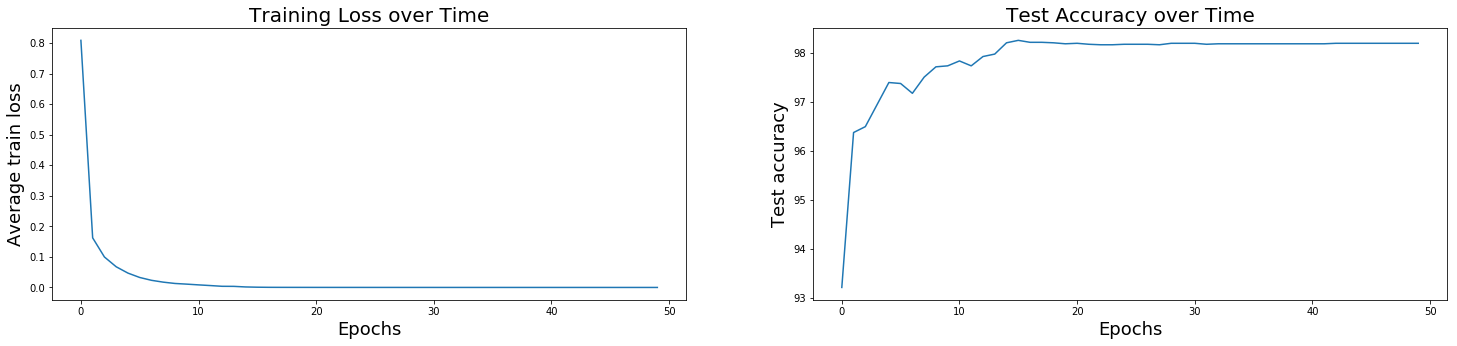

In [60]:
x_axis = np.arange(len(train_loss_over_time))

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=25,h=5)
ax[0].plot(x_axis, train_loss_over_time)
ax[0].set_xlabel('Epochs',fontsize=18)
ax[0].set_ylabel('Average train loss',fontsize=18)
ax[0].set_title('Training Loss over Time',fontsize=20)
ax[1].plot(x_axis, test_accuracy_over_time)
ax[1].set_xlabel('Epochs',fontsize=18)
ax[1].set_ylabel('Test accuracy',fontsize=18)
ax[1].set_title('Test Accuracy over Time',fontsize=20)
fig.savefig('mnist_stats.jpg')


## We attend and accuracy of 98.2%. 